<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2020_0515komazawa_visualize_layers_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# source: /Users/asakawa/study/2020jacobgil_pytorch-explain-black-box.git/explain.py
# title: PyTorch implementation of Interpretable Explanations of Black Boxes by Meaningful Perturbation
# paper:  https://arxiv.org/abs/1704.03296
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np

Given an image $x_0$, our goal is to summarize compactly the effect of deleting image regions in order to explain the behavior of the black box. One approach to this problem is to find deletion regions that are maximally informative.

In order to simplify the discussion, in the rest of the paper we consider black boxes $f(x)\in\mathbb{R}^C$
that generate a vector of scores for different hypotheses about the content of the image (e.g. as a softmax probability layer in a neural  network). 
Then, we consider a “deletion game” where the goal is to find the smallest deletion mask $m$ that causes the
score $f_c(\Phi(x_0; m)) \ll f_c(x_0)$ to drop significantly, where $c$ is the target class. 
Finding $m$ can be formulated as the following learning problem:

$$
m^*=\arg\min_{m\in[0,1]^\Lambda} \lambda\left\|1-m\right\|_1 + f_c(\Phi(x_0;m)) \hspace{5em}(3)
$$

where $\lambda$ encourages most of the mask to be turned off (hence deleting a small subset of $x_0$). 
In this manner, we can find a highly informative region for the network.

One can also play an symmetric “preservation game”, where the goal is to find the smallest subset of the image
that must be retained to preserve the score $f_c(\Phi(x_0; m))\ge f_c(x_0): m^*=\arg\min_{m}\lambda \left\|m\right\|_1 − f_c(\Phi(x_0; m))$. 
The main difference is that the deletion game removes enough evidence to prevent the network from recognizing the object in the image, whereas the preservation game finds a minimal subset of sufficient evidence.

### Iterated gradients. Both optimization problems are
solved by using a local search by means of gradient descent
methods. In this manner, our method extracts information
from the black box f by computing its gradient, similar to
the approach of [15]. However, it differs in that it extracts
this information progressively, over several gradient evaluations, accumulating increasingly more information over
time.

## 4.3. Dealing with artifacts
By committing to finding a single representative perturbation, our approach incurs the risk of triggering artifacts of the black box. 
Neural networks, in particular, are known to be affected by surprising artifacts [5, 10, 7]; these works demonstrate that it is possible to find particular inputs that can drive the neural network to generate nonsensical or unexpected outputs. 
This is not entirely surprising since neural networks are trained discriminatively on natural image statistics. 
While not all artifacts look “unnatural”, nevertheless they form a subset of images that is sampled with negligible probability when the network is operated normally 

Although the existence and characterization of artifacts is an interesting problem per se, we wish to characterize
the behavior of black boxes under normal operating conditions. 
Unfortunately, as illustrated in fig. 5, objectives such as eq. (3) are strongly attracted by such artifacts, and
naively learn subtly-structured deletion masks that trigger them. 
This is particularly true for the noise and constant perturbations as they can more easily than blur create artifacts using sharp color contrasts (fig. 5, bottom row).

We suggests two approaches to avoid such artifacts in generating explanations. The first one is that powerful explanations should, just like any predictor, generalize as much as possible. For the deletion game, this means not relying on the details of a singly-learned mask m. Hence, we reformulate the problem to apply the mask $m$ stochastically, up to small random jitter.

Second, we argue that masks co-adapted with network artifacts are _not representative of natural perturbations_. 
As noted before, the meaning of an explanation depends on the meaning of the changes applied to the input $x$; to obtain a mask more representative of natural perturbations we can encourage it to have a simple, regular structure which cannot be co-adapted to artifacts. We do so by regularizing $m$ in total-variation (TV) norm and upsampling it from a low resolution version.

With these two modifications, eq. (3) becomes:

$$
\min_{m\in[0,1]^\Lambda}=\lambda_1\left\|1-m\right\|_1 + \lambda_2\left\|\nabla m(u)\right\|_\beta^\beta +\mathbb{E}_r\left[f_c(\Phi(x_0(\cdot-\tau),m))\right], \hspace{5em}(4)
$$

where $M(v) = \sum_u g_{\sigma_m}(v/s-u)m(u)$ is the upsampled mask and $g_{\sigma_m}$ is a 2D Gaussian kernel. Equation (4) can be optimized using stochastic gradient descent.


In [0]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

In [0]:
def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
        
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)
        
    preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad = False)


def save(mask, img, blurred):
    mask = mask.cpu().data.numpy()[0]
    mask = np.transpose(mask, (1, 2, 0))
    
    mask = (mask - np.min(mask)) / np.max(mask)
    mask = 1 - mask
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    cam = 1.0*heatmap + np.float32(img)/255
    cam = cam / np.max(cam)
    
    img = np.float32(img) / 255
    perturbated = np.multiply(1 - mask, img) + np.multiply(mask, blurred)   
    
    cv2.imwrite("perturbated.png", np.uint8(255 * perturbated))
    cv2.imwrite("heatmap.png", np.uint8(255 * heatmap))
    cv2.imwrite("mask.png", np.uint8(255 * mask))
    cv2.imwrite("cam.png", np.uint8(255 * cam))


def numpy_to_torch(img, requires_grad = True):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad = requires_grad)
    return v


def load_model():
    model = models.vgg19(pretrained=True)
    model.eval()
    if use_cuda:
        model.cuda()
        
    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = False

    return model

In [6]:
# 自分の PC に入っている画像を試してみましょう
from google.colab import files
uploaded = files.upload()

Saving cat.jpg to cat.jpg


In [7]:
sys.argv[1] = 'cat.jpg'
if __name__ == '__main__':
    #Hyper parameters. 
    #TBD: Use argparse
    tv_beta = 3
    learning_rate = 0.1
    max_iterations = 500
    l1_coeff = 0.01
    tv_coeff = 0.2

    model = load_model()
    original_img = cv2.imread(sys.argv[1], 1)
    original_img = cv2.resize(original_img, (224, 224))
    img = np.float32(original_img) / 255
    blurred_img1 = cv2.GaussianBlur(img, (11, 11), 5)
    blurred_img2 = np.float32(cv2.medianBlur(original_img, 11))/255
    blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
    mask_init = np.ones((28, 28), dtype = np.float32)
    
    # Convert to torch variables
    img = preprocess_image(img)
    blurred_img = preprocess_image(blurred_img2)
    mask = numpy_to_torch(mask_init)

    if use_cuda:
        upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224)).cuda()
    else:
        upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224))
    
    optimizer = torch.optim.Adam([mask], lr=learning_rate)
    target = torch.nn.Softmax()(model(img))
    category = np.argmax(target.cpu().data.numpy())
    print("Category with highest probability", category)
    print("Optimizing.. ")

    for i in range(max_iterations):
        upsampled_mask = upsample(mask)
        # The single channel mask is used with an RGB image, 
        # so the mask is duplicated to have 3 channel,
        upsampled_mask = upsampled_mask.expand(1, 3, upsampled_mask.size(2), upsampled_mask.size(3))
        
        # Use the mask to perturbated the input image.
        perturbated_input = img.mul(upsampled_mask) + blurred_img.mul(1-upsampled_mask)
        
        noise = np.zeros((224, 224, 3), dtype = np.float32)
        cv2.randn(noise, 0, 0.2)
        noise = numpy_to_torch(noise)
        perturbated_input = perturbated_input + noise
                
        outputs = torch.nn.Softmax()(model(perturbated_input))
        loss = l1_coeff*torch.mean(torch.abs(1 - mask)) + tv_coeff*tv_norm(mask, tv_beta) + outputs[0, category]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optional: clamping seems to give better results
        mask.data.clamp_(0, 1)

    upsampled_mask = upsample(mask)
    save(upsampled_mask, original_img, blurred_img_numpy)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Category with highest probability 285
Optimizing.. 


cam.png


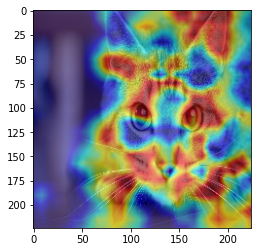

mask.png


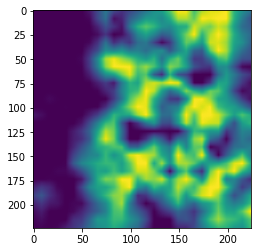

heatmap.png


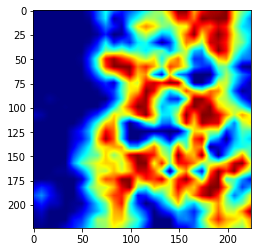

In [9]:
#import IPython.display 
import matplotlib.pyplot as plt
%matplotlib inline

for p in ['cam.png', 'mask.png', 'heatmap.png']:
    print(p)
    plt.imshow(plt.imread(p))
    plt.show()
#    IPython.display.Image(filename=p)
#IPython.display.Image(filename='heatmap.png')